In [1]:
#import libraries
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import io
import requests
import plotly.express as px
import plotly.graph_objects as go

"""
!pip install plotly-geo
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install plotly==4.1.0
"""
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

from google.colab import files
#uploaded = files.upload()

Trevor Ward <br>
tward21@jcu.edu<br>
https://github.com/tward21/NBA_HOF_Predictor <br>
https://www.linkedin.com/in/trevor-ward-35148a17b/<br>
October 26, 2020

# Predicting NBA Hall of Famers Using Machine Learning in Python

With the 2020 NBA season just finishing up, and with LeBron James having secured his fourth NBA finals with his third team, the Los Angeles Lakers, the topic of who is the greatest basketball of all time is often being debated. Being from Cleveland and a huge LeBron bandwagoner, I thought it would be fun to create an assortment of machine learning models in an attempt to predict which players, amongst all who have ever played in NBA history, should definitively make the NBA Hall of Fame, and perhaps at the same time prove which player is truly the Greatest of All Time.

## About the Data

This dataset was scraped from basketball-reference.com using a web scraper, done both using the Python tool BeautifulSoup, as well as by utilizing the Python library Pandas. Player stats and accolades, including things like total points, rebounds, and assists, as well as accolades like number of championships won, total MVP awards, and All NBA Team selections, were found and scraped into pandas DataFrames, allowing for machine learning models to be trained and deployed. Information was scraped for every season from 1950 (the first official season of the NBA) until 2020. 

In [2]:
#scrape per game averages for data visualization using BeautifulSoup
import requests



year = 1950

url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)

page = requests.get(url)

In [3]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page.content, 'html.parser')
soup.findAll('td', limit=2)
# extract text from col headers to list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
headers = headers[1:]


# avoid the first header row -- BBR rank
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]

In [4]:
#create initial dataframe
stats = pd.DataFrame(player_stats, columns = headers)
stats.head()
stats['Year'] = year

In [5]:
#loop that scrapes averages for a year, appends to dataframe, then changes year up until 2020

year = 1951

while year < 2021:
  url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)

  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')

  rows = soup.findAll('tr')[1:]
  player_stats = [[td.getText() for td in rows[i].findAll('td')]
              for i in range(len(rows))]

  newStats = pd.DataFrame(player_stats, columns = headers)
  newStats['Year'] = year
  stats = pd.concat([stats, newStats], axis = 0)
  year+=1

In [6]:
#Remove all rows with NA for player
stats = stats[stats['Player'].notna()]

In [7]:
#replace whitespace with nan
stats = stats.replace('', np.nan)

In [8]:
#columns for visualization
stats = stats[['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'FG', 'FGA', 'FG%', 
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA','TRB', 'AST', 'PF', 'PTS', 'Year']]

## Basic Visualization

In [9]:
#total players per NBA Season, 1950 - 2020
PlayersPerYear = stats['Year'].value_counts().sort_index()
years = stats['Year'].unique()

fig = go.Figure([go.Bar(x=years, y= PlayersPerYear)])
fig.update_layout(title = 'Players By Year', xaxis_title = 'Year', yaxis_title = 'Total Players')
fig.update_layout(hovermode="x")
fig.show()

In [10]:
## Clean up positions so that only 5 main positions remain

stats['Pos'] = stats['Pos'].replace(['G'], 'PG')
stats['Pos'] = stats['Pos'].replace(['G-F'], 'SG')
stats['Pos'] = stats['Pos'].replace(['F'], 'SF')
stats['Pos'] = stats['Pos'].replace(['F-C'], 'PF')
stats['Pos'] = stats['Pos'].replace(['F-G'], 'SG')
stats['Pos'] = stats['Pos'].replace(['SF-SG'], 'SF')
stats['Pos'] = stats['Pos'].replace(['C-PF'], 'C')
stats['Pos'] = stats['Pos'].replace(['C-F'], 'PF')
stats['Pos'] = stats['Pos'].replace(['PF-C'], 'PF')
stats['Pos'] = stats['Pos'].replace(['PG-SG'], 'PG')
stats['Pos'] = stats['Pos'].replace(['SG-PG'], 'SG')
stats['Pos'] = stats['Pos'].replace(['PF-SF'], 'PF')
stats['Pos'] = stats['Pos'].replace(['SG-SF'], 'SG')
stats['Pos'] = stats['Pos'].replace(['SF-PF'], 'SF')
stats['Pos'] = stats['Pos'].replace(['SG-PF'], 'SF')
stats['Pos'] = stats['Pos'].replace(['PG-SF'], 'SG')
stats['Pos'] = stats['Pos'].replace(['C-SF'], 'PF')
stats['Pos'] = stats['Pos'].replace(['SF-PG'], 'SG')

In [11]:
# Plot Position by Year
s = stats.groupby('Year')['Pos'].value_counts()
s = s.unstack()
#posByYearDf = s.reset_index()
#posByYearDf

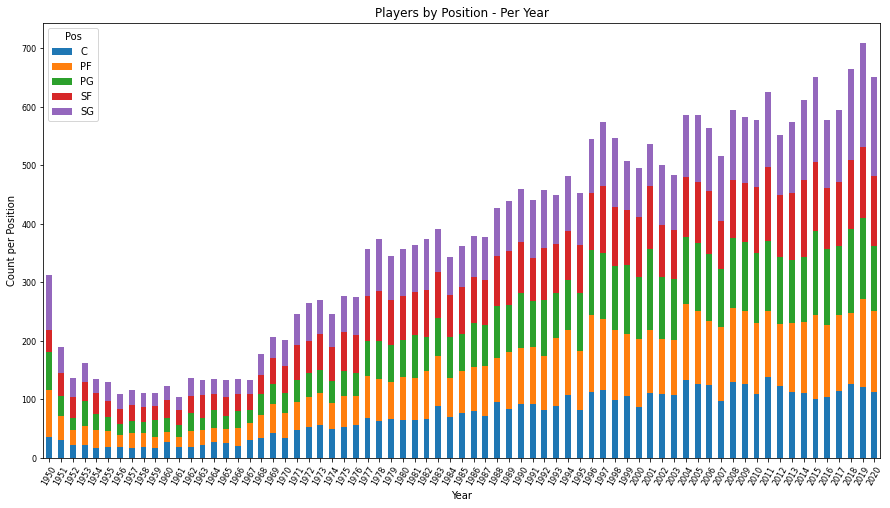

In [12]:
s.plot(kind='bar', stacked=True, rot = 60, figsize = (15,8), fontsize = 8, xlabel = 'Year', ylabel = 'Count per Position', title = 'Players by Position - Per Year' )

In [13]:
stats['PTS'] = pd.to_numeric(stats['PTS'])

ptsByPos = stats[['Year', 'Pos', 'PTS']]

groupedPPP = ptsByPos.groupby(['Year','Pos' ]).mean()


In [14]:
pgppg = groupedPPP[groupedPPP.index.get_level_values(1) == 'PG']
sgppg = groupedPPP[groupedPPP.index.get_level_values(1) == 'SG']
sfppg = groupedPPP[groupedPPP.index.get_level_values(1) == 'SF']
pfppg = groupedPPP[groupedPPP.index.get_level_values(1) == 'PF']
cppg = groupedPPP[groupedPPP.index.get_level_values(1) == 'C']



Text(0, 0.5, 'Points Per Game')

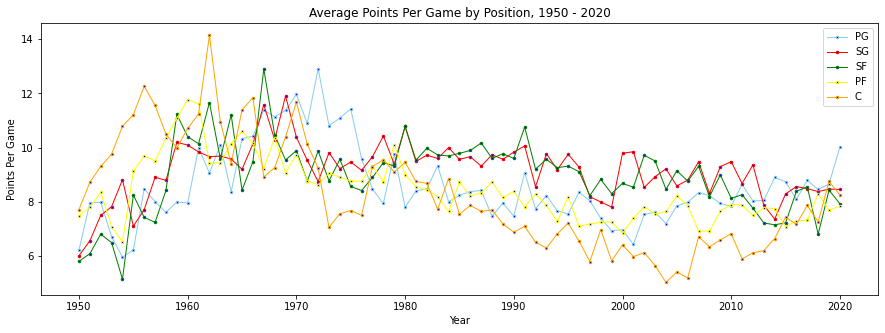

In [15]:
plt.figure(figsize=(15,5))
plt.plot(pgppg.index.get_level_values(0).unique(), 'PTS' , data= pgppg, marker='.', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=1, label = 'PG')
plt.plot(sgppg.index.get_level_values(0).unique(), 'PTS' , data= sgppg, marker='.', markerfacecolor='blue', markersize=5, color='red', linewidth=1, label = 'SG')
plt.plot(sfppg.index.get_level_values(0).unique(), 'PTS' , data= sfppg, marker='.', markerfacecolor='blue', markersize=5, color='green', linewidth=1, label = 'SF')
plt.plot(pfppg.index.get_level_values(0).unique(), 'PTS' , data= pfppg, marker='.', markerfacecolor='blue', markersize=5, color='yellow', linewidth=1, label = 'PF')
plt.plot(cppg.index.get_level_values(0).unique(), 'PTS' , data= cppg, marker='.', markerfacecolor='blue', markersize=5, color='orange', linewidth=1, label = 'C')
plt.legend()
plt.title('Average Points Per Game by Position, 1950 - 2020')
plt.xlabel('Year')
plt.ylabel('Points Per Game')

In [16]:
bron = stats[stats['Player'] == 'LeBron James']
bronPosit = bron['Pos'].value_counts().tolist()

In [17]:
import plotly.graph_objects as go
colors = colors = ['firebrick', 'gold', 'firebrick', 'gold']

fig = go.Figure(go.Pie(
    name = "Lebron James Seasons by Position Listed",
    values = bronPosit ,
    labels = ['SF', 'PF', 'PG', 'SG'],
    text = ["SF", "PF", "PG", "SG"]
    
))
fig.update_traces(hoverinfo='label+percent', textinfo='label+value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=5)))
fig.update_layout(
    title = "LeBron James's Total Years Played by Listed Position")
fig.update_layout(dict(annotations= [{'x': 0.24, 'y':0.95 
                                      ,'text': 'I swear this guy will never retire'
                                      ,'font': { 'color': 'darkgoldenrod', 'size': 16}
                                      ,'showarrow':False, 'xanchor':'center' } ]))
fig.show()

## Scraping, Cleaning Data

In [18]:
year = 1950

url = "https://www.basketball-reference.com/leagues/NBA_{}_totals.html".format(year)

page = requests.get(url)


soup = BeautifulSoup(page.content, 'html.parser')
soup.findAll('td', limit=2)
# extract text from col headers to list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
headers = headers[1:]


# avoid the first header row -- BBR rank
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]


stats = pd.DataFrame(player_stats, columns = headers)
stats.head()
stats['Year'] = year



year = 1951

while year < 2021:
  url = "https://www.basketball-reference.com/leagues/NBA_{}_totals.html".format(year)

  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')

  rows = soup.findAll('tr')[1:]
  player_stats = [[td.getText() for td in rows[i].findAll('td')]
              for i in range(len(rows))]

  newStats = pd.DataFrame(player_stats, columns = headers)
  newStats['Year'] = year
  stats = pd.concat([stats, newStats], axis = 0)
  year+=1

In [19]:
#repeat steps to clean up data from per game df with totals df that was just scraped
stats = stats[stats['Player'].notna()]
stats = stats.replace('', np.nan)


stats = stats[['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'FG', 'FGA', 'FG%', 
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA','TRB', 'AST', 'PF', 'PTS', 'Year']]


stats['Pos'] = stats['Pos'].replace(['G'], 'PG')
stats['Pos'] = stats['Pos'].replace(['G-F'], 'SG')
stats['Pos'] = stats['Pos'].replace(['F'], 'SF')
stats['Pos'] = stats['Pos'].replace(['F-C'], 'PF')
stats['Pos'] = stats['Pos'].replace(['F-G'], 'SG')
stats['Pos'] = stats['Pos'].replace(['SF-SG'], 'SF')
stats['Pos'] = stats['Pos'].replace(['C-PF'], 'C')
stats['Pos'] = stats['Pos'].replace(['C-F'], 'PF')
stats['Pos'] = stats['Pos'].replace(['PF-C'], 'PF')
stats['Pos'] = stats['Pos'].replace(['PG-SG'], 'PG')
stats['Pos'] = stats['Pos'].replace(['SG-PG'], 'SG')
stats['Pos'] = stats['Pos'].replace(['PF-SF'], 'PF')
stats['Pos'] = stats['Pos'].replace(['SG-SF'], 'SG')
stats['Pos'] = stats['Pos'].replace(['SF-PF'], 'SF')
stats['Pos'] = stats['Pos'].replace(['SG-PF'], 'SF')
stats['Pos'] = stats['Pos'].replace(['PG-SF'], 'SG')
stats['Pos'] = stats['Pos'].replace(['C-SF'], 'PF')
stats['Pos'] = stats['Pos'].replace(['SF-PG'], 'SG')

In [20]:
stats = stats.dropna()

#columns needed for championship info, remove name punct, one row per player
newStats = stats[['Player', 'G', 'MP', 'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'TRB', 'AST', 'PF', 'PTS']]
newStats["Player"] = newStats['Player'].str.replace('[^\w\s]','')
newStats = newStats.iloc[:,1:].apply(pd.to_numeric)
newStats['Player'] = stats['Player']

simpleStats = newStats.groupby('Player').sum()

simpleStats = simpleStats.reset_index()

simpleStats["Player"] = simpleStats['Player'].str.replace('[^\w\s]','')


stats['PTS'] = pd.to_numeric(stats['PTS'])

In [21]:
#get awards info from excel
awards = pd.read_excel('https://query.data.world/s/jd356ty4j6ebo3xnadxrvoncx67evf')

simpleAwards = awards[['Year', 'NBA Champion', 'MVP Name']]
#add team abbreviations to match abbreviations in stats df
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Atlanta Hawks',  'ABR'] = 'ATL'	                
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Boston Celtics', 'ABR'] = 'BOS'
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Cleveland Cavaliers', 'ABR'] = 'CLE'
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Chicago Bulls', 'ABR'] = 'CHI'
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Los Angeles Clippers', 'ABR'] = 'LAC'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Golden State Warriors', 'ABR'] = 'GSW'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Charlotte Hornets', 'ABR'] = 'CHA'
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Dallas Mavericks', 'ABR'] = 'DAL'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Denver Nuggets', 'ABR'] = 'DEN'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Detroit Pistons', 'ABR'] = 'DET'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Houston Rockets', 'ABR'] = 'HOU'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Los Angeles Lakers', 'ABR'] = 'LAL'
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Indiana Pacers', 'ABR'] = 'IND'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Minnesota Timberwolves', 'ABR'] = 'MIN'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Memphis Grizzlies', 'ABR'] = 'MEM'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Milwaukee Bucks', 'ABR'] = 'MIL'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Miami Heat', 'ABR'] = 'MIA'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'New York Knicks', 'ABR'] = 'NYK'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'New Orleans Pelicans', 'ABR'] = 'NOP'
simpleAwards.loc[simpleAwards['NBA Champion'] == 'New Orleans Hornets', 'ABR'] = 'NOP'		
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Oklahoma City Thunder', 'ABR'] = 'OKC'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Seattle SuperSonics', 'ABR'] = 'OKC'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Philadelphia 76ers', 'ABR'] = 'PHI'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Portland Trail Blazers', 'ABR'] = 'POR'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Sacramento Kings', 'ABR'] = 'SAC'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Brooklyn Nets', 'ABR'] = 'BKN'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'New Jersey Nets', 'ABR'] = 'BKN'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Toronto Raptors', 'ABR'] = 'TOR'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'San Antonio Spurs', 'ABR'] = 'SAS'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Utah Jazz', 'ABR'] = 'UTA'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Phoenix Suns', 'ABR'] = 'PHX'	
simpleAwards.loc[simpleAwards['NBA Champion'] == 'Washington Wizards', 'ABR'] = 'WSH'	

#add missing data - 2019 and 2020
newRow2019 = {'Year': 2019, 'NBA Champion': 'Toronto Raptors', 'MVP Name': 'Giannis Antetokounmpo', 'ABR': 'TOR'}
newRow2020 = {'Year': 2020, 'NBA Champion': 'Los Angeles Lakers', 'MVP Name': 'Giannis Antetokounmpo', 'ABR': 'LAL'}
simpleAwards['NBA Champion'] = simpleAwards['NBA Champion'].astype(str)
simpleAwards['MVP Name'] = simpleAwards['MVP Name'].astype(str)
simpleAwards['ABR'] = simpleAwards['ABR'].astype(str)




simpleAwards = simpleAwards.append(newRow2019, ignore_index = True)
simpleAwards = simpleAwards.append(newRow2020, ignore_index= True)

stats['numChamps'] = 0
champDf = pd.DataFrame(columns = stats.columns)

#stores info for championships with associated player
for index, row in simpleAwards.iterrows():
    currYear = row['Year']
    currChamp = row['ABR']
    for i, r in stats.iterrows():
      yearForCheck = r['Year']
      if currYear == yearForCheck:
        champCheck = r['Tm']
        if currChamp == champCheck:
          newRow = r.values.tolist()
          champDf = champDf.append(newRow, ignore_index= True)
          champDf.reset_index()

In [22]:
champToList = champDf[0].tolist()
len(champDf[0].tolist())/21

886.0

In [23]:
#reshape data to new championshipDf
newData = np.reshape(champDf[0].tolist(), (886,21))

championDf = pd.DataFrame(data = newData, columns = stats.columns)
championDf['Player'] = championDf['Player'].str.replace('[^\w\s]','')

In [24]:
champsPerPlayer = championDf.groupby('Player').count()
champsByPlayer = champsPerPlayer['numChamps']
champsByPlayer = champsByPlayer.reset_index()

In [25]:
#combine awards with numChamps
#checks champ number in award df, adds that number to grouped stats data
simpleStats['numChamps'] = 0
for index, row in champsByPlayer.iterrows():
  for i, r in simpleStats.iterrows():
    if r['Player'] == row['Player']:
      newChampData = row['numChamps']
      simpleStats.at[i, 'numChamps'] = newChampData    

In [26]:
#get mvp data using pd.read_html
mvpDf = pd.read_html('https://www.basketball-reference.com/awards/mvp.html')
mvpDf = mvpDf[0]
mvpDf.columns = mvpDf.columns.droplevel()
mvpDf = mvpDf[['Player', 'Tm']]
mvpDf = mvpDf.groupby('Player').count().reset_index()
mvpDf["Player"] = mvpDf['Player'].str.replace('[^\w\s]','')

In [27]:
#adds number of MVPs to stats
simpleStats['numMVPs'] = 0
for index, row in mvpDf.iterrows():
    currPlayer = row['Player']
    currMVPs = row['Tm']
    for i, r in simpleStats.iterrows():
      player = r['Player']
      if player == currPlayer:
        simpleStats.at[i, 'numMVPs'] = currMVPs

In [28]:
#get HOF (target) data and add to df
hofDf = pd.read_html('https://www.basketball-reference.com/awards/hof.html')
hofDf = hofDf[0]
hofDf.columns = hofDf.columns.droplevel()
hofDf["Name"] = hofDf['Name'].str.replace('[^\w\s]','')
hofDf = hofDf[hofDf['Category'] == 'Player']
hofDf = hofDf[['Year','Name']]


In [29]:
simpleStats['hallOfFame'] = 0
for index, row in hofDf.iterrows():
    currPlayer = row['Name']
    for i, r in simpleStats.iterrows():
      player = r['Player']
      if player in currPlayer:
        simpleStats.at[i, 'hallOfFame'] = 1


In [30]:
#create target df - players in the hall of fame
targetDf = simpleStats['hallOfFame']

In [31]:
allNba = pd.read_html('https://www.basketball-reference.com/awards/all_league.html')
allNba = allNba[0]
allNba = allNba[allNba['Season'].notna()]

In [32]:
#makes one single string with every name for each all nba team, check if name is in this string during loop to add to stats
allNbaStrings = allNba.iloc[:, 3] + allNba.iloc[:,4] + allNba.iloc[:,5] + allNba.iloc[:,6] + allNba.iloc[:,7]

allNba = allNba[['Season', 'Tm']]

In [33]:
allNba['Players'] = ''
allNba['Players'] = allNbaStrings
allNba["Players"] = allNba['Players'].str.replace('[^\w\s]','')

In [34]:
#adds all first and second team appearences per player
simpleStats['allFirstTeam'] = 0
simpleStats['allSecondTeam'] = 0

for index, row in simpleStats.iterrows():
    currPlayer = row['Player']
    for i, r in allNba.iterrows():
      currString = r['Players']
      whatTeam = r['Tm']
      if currPlayer in currString:
        if whatTeam == '1st':
          simpleStats.at[index, 'allFirstTeam'] += 1
        else:
          simpleStats.at[index, 'allSecondTeam'] +=1

In [35]:
#add all star game appearences

allStarDf = pd.read_html('https://www.basketball-reference.com/awards/all_star_by_player.html')
allStarDf = allStarDf[0]
allStarDf = allStarDf[['Player', 'Tot']]
allStarDf['Player'] = allStarDf['Player'].str.replace('[^\w\s]','')


simpleStats['allStarApps'] = 0

for index, row in allStarDf.iterrows():
    player = row['Player']
    numApps = row['Tot']
    for i, r in simpleStats.iterrows():
      currPlayer = r['Player']
      if currPlayer == player:
        simpleStats.at[i, 'allStarApps'] = numApps

## Modeling

### Very low percentage of players are in the hall of fame right now (about 3 percent of the ~4000 total players that have played all time). The goal is to produce a model that predicts near perfect results, but not 100% accurate, as there are players in the NBA playing today or that recently retired that will most likely make the hall of fame. Creating a model that does not overfit on the data, but does have an accuracy greater than 96% (the accuracy that could be achieved simply by labeling every player as not in the Hall of Fame) requires model tuning by trial and error.

In [36]:
# Very low percentage of players are in the hall of fame, so the goal is to produce a model with 
simpleStats = simpleStats.reset_index()
simpleStats = simpleStats.drop(columns = 'index')
simpleStats['hallOfFame'].value_counts(normalize = True)

0    0.967482
1    0.032518
Name: hallOfFame, dtype: float64

In [37]:
#final df with only necessary columns for modeling
statsX = simpleStats[['G', 'MP', 'FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TRB', 'AST', 'PF', 'PTS', 'numChamps', 'numMVPs', 'allFirstTeam', 'allSecondTeam', 'allStarApps']]

## Feature Correlation

Most of players' in game stats are highly correlated, most so with stats like points and 2pt field goals attempted, and least so with stats like assists and rebounds (most players are likely not to have high numbers of both). Awards info is less correlated, except for all star appearences, which makes sense as it is the award most influenced by having good in game stats, that the most players are allowed to have in a year (only 1 MVP per year, only 5 all NBA Team selections per team, etc).

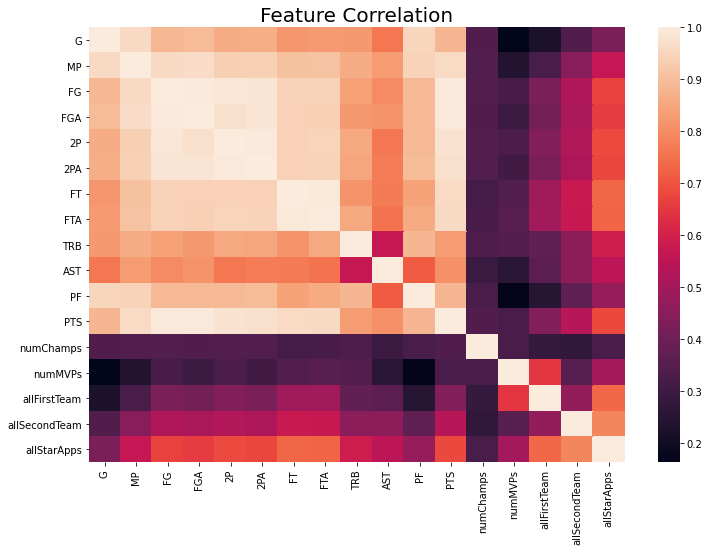

In [38]:
#column correlation

import seaborn as sns
import matplotlib.pyplot as plt

corr = statsX.corr()
plt.subplots(figsize=(12,8))
plt.title('Feature Correlation', fontsize = 20)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Logistic Regression

In [39]:
#LogReg


from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

statsLogReg = scale(statsX)

X_train, X_test, y_train, y_test = train_test_split(
        statsLogReg, targetDf, train_size=0.67, test_size=0.33, random_state=42, shuffle=True)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
prediction = logreg.predict(X_train)
print('Train accuracy score:',accuracy_score(y_train,prediction))
logTestAcc = accuracy_score(y_test,logreg.predict(X_test))
print('Test accuracy score:', logTestAcc)

cm = confusion_matrix(y_train,prediction)
print(cm)

Train accuracy score: 0.9868613138686131
Test accuracy score: 0.9785185185185186
[[2632   13]
 [  23   72]]


### Random Forest

In [40]:
#random forest with notable false positives and negatives
X_train, X_test, y_train, y_test = train_test_split(
        statsX, targetDf, train_size=0.67, test_size=0.33, random_state=42, shuffle=True)


from sklearn.ensemble import RandomForestClassifier as RFC
rfc_b = RFC(n_estimators=1000,max_depth = 4, random_state=42)
rfc_b.fit(X_train,y_train)
prediction = rfc_b.predict(X_train)
testPred = rfc_b.predict(X_test)
print('Train accuracy score:',accuracy_score(y_train,prediction))
RFTestAcc = accuracy_score(y_test, testPred)
print('Test accuracy score:', RFTestAcc)

cm = confusion_matrix(y_test, testPred)
print(cm)

Train accuracy score: 0.9897810218978103
Test accuracy score: 0.9807407407407407
[[1303    9]
 [  17   21]]


All star game appearences appears to be the stat most indicative of whether a player will make the Hall of Fame or not. This makes sense, as All Star Game appearences are a good measure of for how many years a player has stood apart as a 'star' player. More than 20 players total can make the all star game each year, so it is a good way to keep track of and predict the top players in the game over time.

In [41]:
featImp = rfc_b.feature_importances_
feats = statsX.columns
features_tuple = list(zip(feats, featImp))
featureDf = pd.DataFrame(features_tuple, columns= ['features', 'importances'])
fig = px.bar(featureDf, x='features', y='importances', title = 'Feature Importances')
fig.show()

In [42]:
FP = X_test[(y_test == 1) & (testPred == 0)]
FN = X_test[(y_test == 0) & (testPred == 1)]
trainFP = X_train[(y_train == 1) & (prediction == 0)]
trainFN = X_train[(y_train == 0) & (prediction == 1)]


In [43]:
t = simpleStats[simpleStats.index.isin(targetDf[targetDf==1].index)]

### Notable False Positives classified by the Random Forest - the most accurate of my measured models. These players represent those who are not actually in the Hall of Fame (yet?), but that the model classifies as being in the Hall of Fame.

In [44]:
#notable players RF thinks should be in HOF from test and train data

print(simpleStats[simpleStats.index.isin(FN.index)]['Player'])
print(simpleStats[simpleStats.index.isin(trainFN.index)]['Player'])

691          Chris Webber
1110        Dirk Nowitzki
1210          Dwyane Wade
1775         James Harden
2347         Kevin Durant
2431    LaMarcus Aldridge
2459          Larry Foust
2494         LeBron James
3061            Pau Gasol
Name: Player, dtype: object
171         Anthony Davis
580       Carmelo Anthony
681            Chris Paul
1206        Dwight Howard
3079          Paul Pierce
3426    Russell Westbrook
Name: Player, dtype: object


#### Sample of one random tree from the random forest

In [45]:
#one random tree from list
from sklearn.tree import export_graphviz


estimator = rfc_b.estimators_[5]


export_graphviz(estimator, out_file='tree.dot', 
                feature_names = statsX.columns,
                class_names = ['0','HOF'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

### Nearest Neighbors Clasifier

In [46]:
#KNN
#same split from last model

from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
prediction = knn.predict(X_train)
print('Train accuracy score:',accuracy_score(y_train,prediction))
KNNTestAcc = accuracy_score(y_test,knn.predict(X_test))
print('Test accuracy score:', KNNTestAcc)

cm = confusion_matrix(y_train, prediction)
print(cm)

Train accuracy score: 0.9759124087591241
Test accuracy score: 0.9696296296296296
[[2630   15]
 [  51   44]]


XGBoost Classifier

In [47]:
#Gradient Boost

import xgboost
from xgboost import XGBClassifier


model = XGBClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

prediction = model.predict(X_train)

print('Train accuracy score:',accuracy_score(y_train,prediction))
XGBTestAcc = accuracy_score(y_test,model.predict(X_test))
print('Test accuracy score:', XGBTestAcc)


cm = confusion_matrix(y_test, model.predict(X_test))
print(cm)


Train accuracy score: 0.9923357664233576
Test accuracy score: 0.9777777777777777
[[1300   12]
 [  18   20]]


### Support Vector Machine

In [48]:
#SVM

from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly', degree = 5) # Polynomial Kernel


clf.fit(X_train, y_train)

prediction = clf.predict(X_test)


print('Train accuracy score:',accuracy_score(y_train,clf.predict(X_train)))
SVMTestAcc = accuracy_score(y_test,prediction)
print('Test accuracy score:', SVMTestAcc)

cm = confusion_matrix(y_test, clf.predict(X_test))
print(cm)

Train accuracy score: 0.9868613138686131
Test accuracy score: 0.9740740740740741
[[1299   13]
 [  22   16]]


### Keras Neural Network

In [49]:
#keras neural network for predicting probabilities

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adagrad

statsScaled = scale(statsX)
statsNN = pd.DataFrame(statsScaled, index=statsX.index, columns=statsX.columns)

X_train, X_test, y_train, y_test = train_test_split(
        statsNN, targetDf, train_size=0.67, test_size=0.33, random_state=42, shuffle=True)

#complex model with 4 layers because of number of features and samples, done by trial and error
model = Sequential()
model.add(Dense(32, input_dim=17, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
sgd = SGD(lr=0.2)
model.compile(loss='mean_squared_error', optimizer='SGD' ,metrics=['accuracy'])
# fit the keras model on the dataset
history = model.fit(X_train, y_train,batch_size=9, epochs=60)
history
prediction = model.predict(X_train)
print('Train accuracy score:',model.evaluate(X_train, y_train, verbose = 0))
NNTestAcc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy score:',NNTestAcc)

Epoch 1/60
305/305 [==============================] - 0s 831us/step - loss: 0.0739 - accuracy: 0.9646
Epoch 2/60
305/305 [==============================] - 0s 857us/step - loss: 0.0346 - accuracy: 0.9697
Epoch 3/60
305/305 [==============================] - 0s 857us/step - loss: 0.0243 - accuracy: 0.9741
Epoch 4/60
305/305 [==============================] - 0s 816us/step - loss: 0.0198 - accuracy: 0.9777
Epoch 5/60
305/305 [==============================] - 0s 800us/step - loss: 0.0178 - accuracy: 0.9803
Epoch 6/60
305/305 [==============================] - 0s 878us/step - loss: 0.0165 - accuracy: 0.9807
Epoch 7/60
305/305 [==============================] - 0s 821us/step - loss: 0.0156 - accuracy: 0.9807
Epoch 8/60
305/305 [==============================] - 0s 818us/step - loss: 0.0149 - accuracy: 0.9814
Epoch 9/60
305/305 [==============================] - 0s 813us/step - loss: 0.0144 - accuracy: 0.9818
Epoch 10/60
305/305 [==============================] - 0s 798us/step - loss: 0.014

In [50]:
testPred = model.predict(X_test)
trainPred = model.predict(X_train)
cm = confusion_matrix(y_test, model.predict(X_test).round())
print(cm)

[[1300   12]
 [  15   23]]


### Model Test Scores

Since it is difficult to tell what models will perform best on a given dataset, an assortment of models were tested to see which format returned the best results. Models were trained using trained using Sklearn's library train-test split to break up the stats dataframe into a train and validation dataset (split into thirds, 67% and 33% respectively). The most accurate of these models was the normal Random Forest model, followed closely by the Keras neural network. Feature importances were produced by the Logistic Regression model. All models were trained on the X_training dataset, with validation data containing the actual values of who is in the Hall of Fame coming from the targetDf. Models were then all tested on the 33% validation data, all of which the model had not yet seen. Accuracy scores in the graph below represent accuracies of each model on the validation data. <br>

In [51]:
#Plot model test scores
modelNames = ['LogReg', 'RandomForest', 'NearestNeighbor', 'XGBoost', 'SVM', 'NeuralNetwork']
modelScores = [logTestAcc, RFTestAcc, KNNTestAcc, XGBTestAcc, SVMTestAcc, NNTestAcc[1]]
models_tuple = list(zip(modelNames, modelScores))
modelAccuracies = pd.DataFrame(models_tuple, columns= ['ModelNames', 'ModelPercentAccurate'])
modelAccuracies['ModelPercentAccurate'] = modelAccuracies['ModelPercentAccurate'].round(4)
modelAccuracies.sort_values(by = 'ModelPercentAccurate', ascending = False)

,ModelNames,ModelPercentAccurate
1,RandomForest,0.9807
5,NeuralNetwork,0.9800
0,LogReg,0.9785
3,XGBoost,0.9778
4,SVM,0.9741
2,NearestNeighbor,0.9696


In [52]:
FP = X_test[(y_test == 1) & (testPred.round().flatten == 0)]
FN = X_test[(y_test == 0) & (testPred.round().flatten() == 1)]
trainFP = X_train[(y_train == 1) & (trainPred.round().flatten() == 0)]
trainFN = X_train[(y_train == 0) & (trainPred.round().flatten() == 1)]

In [53]:
#adds predicted to both train and test
#add player back to see who model is predicting
#combines X, appends prediction to statsX
X_train['Pred'] = trainPred*100
X_test['Pred'] = testPred*100
statsX['Player'] = simpleStats['Player']
totalX = pd.concat([X_train, X_test], ignore_index=False)
totalX = totalX.sort_index()

In [54]:
#add predicted to df
simpleStats['PredConfidence'] = 0.000
for i, r in simpleStats.iterrows():
  for index, row in totalX.iterrows():
    if i == index:
      toChange = row['Pred']
      simpleStats.at[i, 'PredConfidence'] = round(toChange, 3) 


  

Predictions for current players can also be leveraged by using the Keras Neural Network. Since the network produces 2 percentages, how confident it is a certain player is in the Hall of Fame and how confident they are not, predictions on how likely each player is to make the Hall of Fame can be explored. Below are graphs depicting the players with the highest probability of making the Hall of Fame, as well as some notable False Positives, players the model predicted should be in the Hall of Fame that are not, and False Negatives, players that the model believes should not be in the Hall of Fame that are.  

In [55]:
#Players not in the hall of fame that the model predicts should be
simpleStats = simpleStats.drop(413)
simpleStats = simpleStats.drop(3055)
sigFalsePos = simpleStats[simpleStats['PredConfidence'] >= 50]
sigFalsePos = sigFalsePos[sigFalsePos['hallOfFame']==0]
topFP = sigFalsePos.sort_values(by = 'PredConfidence').tail(15)


FPTuple = list(zip(topFP['Player'], topFP['PredConfidence']))
FPDf = pd.DataFrame(FPTuple, columns= ['Players', 'Predicted'])

fig = px.bar(FPDf, x='Players', y='Predicted', title = 'Notable False Positives')
fig.show()

In [56]:
#players in the hall of fame that the model predicts should not be
sigFalseNeg = simpleStats[simpleStats['PredConfidence'] <= 50]
sigFalseNeg = sigFalseNeg[sigFalseNeg['hallOfFame']==1]
topFN = sigFalseNeg.sort_values(by = 'PredConfidence').tail(15)

FNTuple = list(zip(topFN['Player'], topFN['PredConfidence']))
FNDf = pd.DataFrame(FNTuple, columns= ['Players', 'Predicted'])

fig = px.bar(FNDf, x='Players', y='Predicted', title = 'Notable False Negatives')
fig.show()

In [57]:
#method for finding how confident model is that X player will make HOF
def find_HOF(playerFirst_Last):
  playerDf = simpleStats[simpleStats['Player'] == playerFirst_Last]
  playerDf = playerDf[['Player', 'PredConfidence']]


  return playerDf

In [59]:
topAll = simpleStats.sort_values(by = 'PredConfidence', ascending = False).head(15)


topTuple = list(zip(topAll['Player'], topAll['PredConfidence']))
topDf = pd.DataFrame(topTuple, columns= ['Players', 'Predicted'])

fig = px.bar(topDf, x='Players', y='Predicted', title = 'Top Players by Predicted %')
fig.show()

## Conclusion 
<br>
It seems machine learning can in fact be successfully applied to NBA data to give an idea of what players should and should not be in the NBA's Hall of Fame. This has been my favorite machine learning project to work on to date, as I'm a huge NBA fan and I found it to be very insightful exploring what type of accolades, accomplishments, and overall careers often lead to being immortalized in the Naismith Hall of Fame. This project has lead me to ask the question, should machine learning algorithms be applied to NBA career data to determine if someone should or should not be enshrined? Is it a good thing that the honor is voted on by humans instead? <br>
<br>
Thanks for reading!
<br>
<br>
Some fun predictions for my fellow Cleveland fans below


In [63]:
find_HOF('LeBron James')

,Player,PredConfidence
2494,LeBron James,99.778


In [60]:
find_HOF('Kevin Love')

,Player,PredConfidence
2361,Kevin Love,31.175


In [61]:
find_HOF('Stephen Curry')

,Player,PredConfidence
3598,Stephen Curry,87.645


In [62]:
find_HOF('Draymond Green')

,Player,PredConfidence
1181,Draymond Green,34.607
